In [1]:
import math
import numpy as np
import yfinance as yf
import pandas_datareader as web
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
plt.style.use('seaborn')

In [2]:
df = web.DataReader('XRP-USD', data_source='yahoo', start = '2017-01-01', end = '2021-10-01')

In [3]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-01,0.006702,0.006334,0.006523,0.006368,4.189780e+05,0.006368
2017-01-02,0.006437,0.006281,0.006386,0.006311,1.046250e+06,0.006311
2017-01-03,0.006392,0.006278,0.006290,0.006386,1.014830e+06,0.006386
2017-01-04,0.006656,0.006385,0.006385,0.006570,1.642730e+06,0.006570
2017-01-05,0.006580,0.006031,0.006572,0.006201,4.058170e+06,0.006201
...,...,...,...,...,...,...
2021-09-27,0.942593,0.892499,0.923059,0.893689,2.818991e+09,0.893689
2021-09-28,0.990350,0.887948,0.894591,0.928349,3.558174e+09,0.928349
2021-09-29,0.964081,0.922919,0.927513,0.952636,3.051317e+09,0.952636


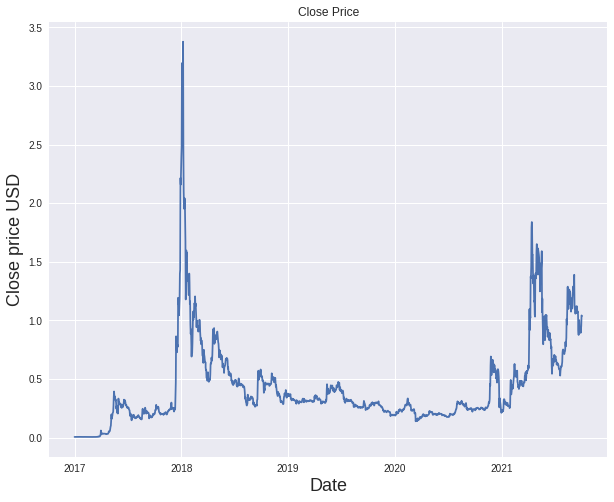

In [4]:
plt.figure(figsize=(10, 8))
plt.title('Close Price')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD', fontsize=18)
plt.show()

# preparing the training data

In [5]:
data = df.filter(['Close'])
dataset = data.values
trainig_data_len = math.ceil(len(dataset)* 0.8)
trainig_data_len

1386

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[2.84663530e-04],
       [2.67761571e-04],
       [2.90001013e-04],
       ...,
       [2.80876361e-01],
       [3.07560011e-01],
       [3.06389022e-01]])

In [7]:
volume = df.filter(['Volume'])
scaled_volume = scaler.fit_transform(volume)
volume_train_data = scaled_volume[0:trainig_data_len, :]

In [8]:
#the last 60 days to predict one day in future
train_data = scaled_data[0:trainig_data_len, :]
x_train = []
y_train = []
volume_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    volume_train.append(np.mean(volume_train_data[i-60:i, 0]))
    #y_train.append(train_data[i, 0])
    if (train_data[i,0] >= train_data[i-1,0]):
        #price goes up
        y_train.append(1)
    else:
        #price goes down
        y_train.append(0)

In [9]:
x_train, y_train, volume_train = np.array(x_train), np.array(y_train), np.array(volume_train)

In [10]:
columns = []
for i in range(60):
    x = 'x' + str(i)
    columns.append(x)

In [11]:
dataf = pd.DataFrame(data=x_train, columns=columns)
dataf['target'] = y_train
dataf['volume'] = volume_train
dataf

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x52,x53,x54,x55,x56,x57,x58,x59,target,volume
0,0.000285,0.000268,0.000290,0.000345,0.000235,0.000269,0.000284,0.000245,0.000225,0.000383,...,0.000134,0.000144,0.000087,0.000076,0.000078,0.000060,0.000038,0.000000,1,0.000023
1,0.000268,0.000290,0.000345,0.000235,0.000269,0.000284,0.000245,0.000225,0.000383,0.000297,...,0.000144,0.000087,0.000076,0.000078,0.000060,0.000038,0.000000,0.000173,1,0.000024
2,0.000290,0.000345,0.000235,0.000269,0.000284,0.000245,0.000225,0.000383,0.000297,0.000301,...,0.000087,0.000076,0.000078,0.000060,0.000038,0.000000,0.000173,0.000276,0,0.000025
3,0.000345,0.000235,0.000269,0.000284,0.000245,0.000225,0.000383,0.000297,0.000301,0.000352,...,0.000076,0.000078,0.000060,0.000038,0.000000,0.000173,0.000276,0.000264,0,0.000025
4,0.000235,0.000269,0.000284,0.000245,0.000225,0.000383,0.000297,0.000301,0.000352,0.000431,...,0.000078,0.000060,0.000038,0.000000,0.000173,0.000276,0.000264,0.000214,0,0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,0.087253,0.088389,0.091733,0.088334,0.084461,0.085151,0.081625,0.083364,0.083020,0.084156,...,0.071300,0.072243,0.073006,0.073800,0.074223,0.072364,0.071324,0.069694,1,0.041200
1322,0.088389,0.091733,0.088334,0.084461,0.085151,0.081625,0.083364,0.083020,0.084156,0.080809,...,0.072243,0.073006,0.073800,0.074223,0.072364,0.071324,0.069694,0.069838,1,0.040710
1323,0.091733,0.088334,0.084461,0.085151,0.081625,0.083364,0.083020,0.084156,0.080809,0.080679,...,0.073006,0.073800,0.074223,0.072364,0.071324,0.069694,0.069838,0.070222,1,0.040331
1324,0.088334,0.084461,0.085151,0.081625,0.083364,0.083020,0.084156,0.080809,0.080679,0.076830,...,0.073800,0.074223,0.072364,0.071324,0.069694,0.069838,0.070222,0.071331,0,0.039625


In [12]:
volume_train = np.reshape( volume_train , newshape = (volume_train.shape[0],1) )

x_train_with_volume = np.concatenate((x_train, volume_train), axis = 1)

# preparing the test data

In [13]:
volume_test_data = scaled_volume[trainig_data_len -60:, :]
test_data = scaled_data[trainig_data_len -60:, : ]
x_test = []
y_test = []
volume_test = []
#y_test = dataset[trainig_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    volume_test.append(np.mean(volume_test_data[i-60:i, 0]))
    
    if (test_data[i,0] >= test_data[i-1,0]):
        #price goes up
        y_test.append(1)
    else:
        #price goes down
        y_test.append(0)

In [14]:
x_test, volume_test = np.array(x_test), np.array(volume_test)

volume_test = np.reshape( volume_test , newshape = (volume_test.shape[0],1) )

x_test_with_volume = np.concatenate((x_test, volume_test), axis = 1)
x_train_with_volume.shape

(1326, 61)

# Creating the model

In [15]:
from keras.layers import Flatten
import tensorflow as tf

In [16]:
#y_train = keras.utils.to_categorical(y_train, 2)

In [17]:
model = Sequential()
#model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[0], 1)))
#model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[0], 1)))
#model.add(LSTM(50, return_sequences = False))
model.add(Dense(61, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer= 'adam',metrics=['BinaryAccuracy'], loss = 'binary_crossentropy')

In [41]:
model.fit(x = x_train_with_volume, y =  y_train, batch_size =32, epochs = 600
          , validation_data = (x_test_with_volume, np.array(y_test)))

Epoch 1/600
42/42 [==============================] - 0s 4ms/step - loss: 0.6845 - binary_accuracy: 0.5528 - val_loss: 0.7057 - val_binary_accuracy: 0.4855
Epoch 2/600
42/42 [==============================] - 0s 4ms/step - loss: 0.6849 - binary_accuracy: 0.5475 - val_loss: 0.7065 - val_binary_accuracy: 0.4769
Epoch 3/600
42/42 [==============================] - 0s 5ms/step - loss: 0.6844 - binary_accuracy: 0.5513 - val_loss: 0.7061 - val_binary_accuracy: 0.4740
Epoch 4/600
42/42 [==============================] - 0s 6ms/step - loss: 0.6845 - binary_accuracy: 0.5520 - val_loss: 0.7053 - val_binary_accuracy: 0.4884
Epoch 5/600
42/42 [==============================] - 0s 6ms/step - loss: 0.6848 - binary_accuracy: 0.5505 - val_loss: 0.7070 - val_binary_accuracy: 0.4827
Epoch 6/600
42/42 [==============================] - 0s 4ms/step - loss: 0.6842 - binary_accuracy: 0.5513 - val_loss: 0.7059 - val_binary_accuracy: 0.4855
Epoch 7/600
42/42 [==============================] - 0s 6ms/step - los

42/42 [==============================] - 0s 3ms/step - loss: 0.6836 - binary_accuracy: 0.5528 - val_loss: 0.7064 - val_binary_accuracy: 0.4884
Epoch 54/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6833 - binary_accuracy: 0.5535 - val_loss: 0.7061 - val_binary_accuracy: 0.4884
Epoch 55/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6835 - binary_accuracy: 0.5505 - val_loss: 0.7060 - val_binary_accuracy: 0.4855
Epoch 56/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6831 - binary_accuracy: 0.5543 - val_loss: 0.7059 - val_binary_accuracy: 0.4855
Epoch 57/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6833 - binary_accuracy: 0.5483 - val_loss: 0.7051 - val_binary_accuracy: 0.4855
Epoch 58/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6830 - binary_accuracy: 0.5566 - val_loss: 0.7065 - val_binary_accuracy: 0.4913
Epoch 59/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6

42/42 [==============================] - 0s 3ms/step - loss: 0.6810 - binary_accuracy: 0.5573 - val_loss: 0.7050 - val_binary_accuracy: 0.4682
Epoch 106/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6804 - binary_accuracy: 0.5581 - val_loss: 0.7061 - val_binary_accuracy: 0.4769
Epoch 107/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6803 - binary_accuracy: 0.5535 - val_loss: 0.7054 - val_binary_accuracy: 0.4740
Epoch 108/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6799 - binary_accuracy: 0.5603 - val_loss: 0.7063 - val_binary_accuracy: 0.4682
Epoch 109/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6797 - binary_accuracy: 0.5611 - val_loss: 0.7059 - val_binary_accuracy: 0.4682
Epoch 110/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6799 - binary_accuracy: 0.5543 - val_loss: 0.7074 - val_binary_accuracy: 0.4711
Epoch 111/600
42/42 [==============================] - 0s 3ms/step - los

42/42 [==============================] - 0s 3ms/step - loss: 0.6743 - binary_accuracy: 0.5641 - val_loss: 0.7073 - val_binary_accuracy: 0.4624
Epoch 158/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6745 - binary_accuracy: 0.5694 - val_loss: 0.7051 - val_binary_accuracy: 0.4653
Epoch 159/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6746 - binary_accuracy: 0.5551 - val_loss: 0.7078 - val_binary_accuracy: 0.4711
Epoch 160/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6751 - binary_accuracy: 0.5679 - val_loss: 0.7068 - val_binary_accuracy: 0.4653
Epoch 161/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6748 - binary_accuracy: 0.5618 - val_loss: 0.7085 - val_binary_accuracy: 0.4624
Epoch 162/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6746 - binary_accuracy: 0.5611 - val_loss: 0.7075 - val_binary_accuracy: 0.4624
Epoch 163/600
42/42 [==============================] - 0s 3ms/step - los

42/42 [==============================] - 0s 3ms/step - loss: 0.6699 - binary_accuracy: 0.5716 - val_loss: 0.7051 - val_binary_accuracy: 0.4566
Epoch 210/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6700 - binary_accuracy: 0.5724 - val_loss: 0.7042 - val_binary_accuracy: 0.4624
Epoch 211/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6710 - binary_accuracy: 0.5732 - val_loss: 0.7036 - val_binary_accuracy: 0.4566
Epoch 212/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6717 - binary_accuracy: 0.5626 - val_loss: 0.7034 - val_binary_accuracy: 0.4566
Epoch 213/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6701 - binary_accuracy: 0.5671 - val_loss: 0.7043 - val_binary_accuracy: 0.4566
Epoch 214/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6695 - binary_accuracy: 0.5754 - val_loss: 0.7041 - val_binary_accuracy: 0.4595
Epoch 215/600
42/42 [==============================] - 0s 3ms/step - los

42/42 [==============================] - 0s 3ms/step - loss: 0.6646 - binary_accuracy: 0.5709 - val_loss: 0.7028 - val_binary_accuracy: 0.4682
Epoch 262/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6636 - binary_accuracy: 0.5822 - val_loss: 0.7027 - val_binary_accuracy: 0.4740
Epoch 263/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6640 - binary_accuracy: 0.5784 - val_loss: 0.7045 - val_binary_accuracy: 0.4682
Epoch 264/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6635 - binary_accuracy: 0.5792 - val_loss: 0.7051 - val_binary_accuracy: 0.4711
Epoch 265/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6641 - binary_accuracy: 0.5754 - val_loss: 0.7021 - val_binary_accuracy: 0.4538
Epoch 266/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6645 - binary_accuracy: 0.5701 - val_loss: 0.7031 - val_binary_accuracy: 0.4682
Epoch 267/600
42/42 [==============================] - 0s 3ms/step - los

42/42 [==============================] - 0s 3ms/step - loss: 0.6622 - binary_accuracy: 0.5784 - val_loss: 0.7127 - val_binary_accuracy: 0.4682
Epoch 314/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6645 - binary_accuracy: 0.5679 - val_loss: 0.7086 - val_binary_accuracy: 0.4538
Epoch 315/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6567 - binary_accuracy: 0.5830 - val_loss: 0.7117 - val_binary_accuracy: 0.4566
Epoch 316/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6567 - binary_accuracy: 0.5814 - val_loss: 0.7108 - val_binary_accuracy: 0.4653
Epoch 317/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6587 - binary_accuracy: 0.5792 - val_loss: 0.7111 - val_binary_accuracy: 0.4653
Epoch 318/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6581 - binary_accuracy: 0.5784 - val_loss: 0.7112 - val_binary_accuracy: 0.4538
Epoch 319/600
42/42 [==============================] - 0s 3ms/step - los

42/42 [==============================] - 0s 3ms/step - loss: 0.6526 - binary_accuracy: 0.5807 - val_loss: 0.7190 - val_binary_accuracy: 0.4711
Epoch 366/600
42/42 [==============================] - 0s 4ms/step - loss: 0.6531 - binary_accuracy: 0.5799 - val_loss: 0.7240 - val_binary_accuracy: 0.4566
Epoch 367/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6523 - binary_accuracy: 0.5830 - val_loss: 0.7236 - val_binary_accuracy: 0.4509
Epoch 368/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6538 - binary_accuracy: 0.5792 - val_loss: 0.7258 - val_binary_accuracy: 0.4624
Epoch 369/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6518 - binary_accuracy: 0.5845 - val_loss: 0.7221 - val_binary_accuracy: 0.4566
Epoch 370/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6514 - binary_accuracy: 0.5807 - val_loss: 0.7253 - val_binary_accuracy: 0.4595
Epoch 371/600
42/42 [==============================] - 0s 3ms/step - los

42/42 [==============================] - 0s 3ms/step - loss: 0.6473 - binary_accuracy: 0.5882 - val_loss: 0.7370 - val_binary_accuracy: 0.4538
Epoch 418/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6475 - binary_accuracy: 0.5897 - val_loss: 0.7361 - val_binary_accuracy: 0.4682
Epoch 419/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6479 - binary_accuracy: 0.5860 - val_loss: 0.7364 - val_binary_accuracy: 0.4682
Epoch 420/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6498 - binary_accuracy: 0.5739 - val_loss: 0.7316 - val_binary_accuracy: 0.4566
Epoch 421/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6484 - binary_accuracy: 0.5860 - val_loss: 0.7373 - val_binary_accuracy: 0.4538
Epoch 422/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6468 - binary_accuracy: 0.5814 - val_loss: 0.7373 - val_binary_accuracy: 0.4653
Epoch 423/600
42/42 [==============================] - 0s 3ms/step - los

42/42 [==============================] - 0s 3ms/step - loss: 0.6422 - binary_accuracy: 0.5905 - val_loss: 0.7439 - val_binary_accuracy: 0.4624
Epoch 470/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6461 - binary_accuracy: 0.5799 - val_loss: 0.7439 - val_binary_accuracy: 0.4451
Epoch 471/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6419 - binary_accuracy: 0.5852 - val_loss: 0.7506 - val_binary_accuracy: 0.4480
Epoch 472/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6407 - binary_accuracy: 0.5943 - val_loss: 0.7559 - val_binary_accuracy: 0.4335
Epoch 473/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6447 - binary_accuracy: 0.5867 - val_loss: 0.7503 - val_binary_accuracy: 0.4451
Epoch 474/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6430 - binary_accuracy: 0.5897 - val_loss: 0.7529 - val_binary_accuracy: 0.4624
Epoch 475/600
42/42 [==============================] - 0s 3ms/step - los

42/42 [==============================] - 0s 3ms/step - loss: 0.6410 - binary_accuracy: 0.5897 - val_loss: 0.7816 - val_binary_accuracy: 0.4364
Epoch 522/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6379 - binary_accuracy: 0.5845 - val_loss: 0.7721 - val_binary_accuracy: 0.4509
Epoch 523/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6433 - binary_accuracy: 0.5913 - val_loss: 0.7675 - val_binary_accuracy: 0.4538
Epoch 524/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6359 - binary_accuracy: 0.5958 - val_loss: 0.7712 - val_binary_accuracy: 0.4624
Epoch 525/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6395 - binary_accuracy: 0.5807 - val_loss: 0.7945 - val_binary_accuracy: 0.4480
Epoch 526/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6395 - binary_accuracy: 0.5867 - val_loss: 0.7885 - val_binary_accuracy: 0.4566
Epoch 527/600
42/42 [==============================] - 0s 3ms/step - los

42/42 [==============================] - 0s 3ms/step - loss: 0.6351 - binary_accuracy: 0.5980 - val_loss: 0.8044 - val_binary_accuracy: 0.4393
Epoch 574/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6396 - binary_accuracy: 0.5897 - val_loss: 0.8074 - val_binary_accuracy: 0.4509
Epoch 575/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6323 - binary_accuracy: 0.5928 - val_loss: 0.8170 - val_binary_accuracy: 0.4566
Epoch 576/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6332 - binary_accuracy: 0.5988 - val_loss: 0.8274 - val_binary_accuracy: 0.4538
Epoch 577/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6326 - binary_accuracy: 0.6048 - val_loss: 0.8053 - val_binary_accuracy: 0.4451
Epoch 578/600
42/42 [==============================] - 0s 3ms/step - loss: 0.6327 - binary_accuracy: 0.5890 - val_loss: 0.8074 - val_binary_accuracy: 0.4538
Epoch 579/600
42/42 [==============================] - 0s 3ms/step - los

# ploting the losses to see when overfitting is happening

<AxesSubplot:>

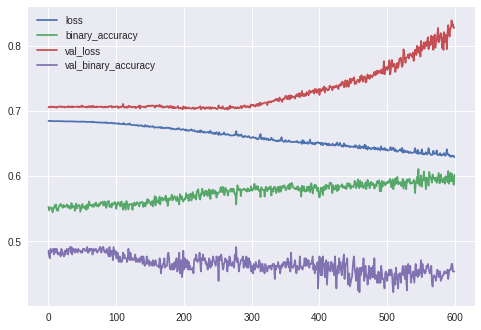

In [42]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [43]:
predictions = model.predict(x_test_with_volume)
prediction = tf.greater(predictions, 0.5)
prediction = tf.cast(prediction, tf.int32)
#predictions = scaler.inverse_transform(predictions)

In [44]:
compare = pd.DataFrame(data=y_test, columns=['real values'])
compare['predictions'] = np.array(prediction)
compare

,real values,predictions
0,1,0
1,0,0
2,1,0
3,0,0
4,0,0
...,...,...
341,0,0
342,1,0
343,1,0
344,1,0


# confusion matrix and classification report

In [45]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,prediction))

[[113  53]
 [136  44]]


In [46]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.45      0.68      0.54       166
           1       0.45      0.24      0.32       180

    accuracy                           0.45       346
   macro avg       0.45      0.46      0.43       346
weighted avg       0.45      0.45      0.43       346



# Trying a new data point

In [47]:
real_pred = web.DataReader('XRP-USD', data_source='yahoo', start = '2020-01-01', end = '2021-10-03')
new_df = real_pred.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.fit_transform(last_60_days)

X_test = np.array(last_60_days_scaled)
X_text = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

In [48]:
volume_df = real_pred.filter(['Volume'])
volume_last_60 = volume_df[-60:].values
volume_last_60_scaled = scaler.fit_transform(volume_last_60)
mean_volume = np.mean(volume_last_60_scaled)
mean_volume_arr = []
mean_volume_arr.append(mean_volume)

X_test = np.append(X_test, np.array(mean_volume))
X_test

array([0.        , 0.02036076, 0.12667198, 0.06946609, 0.13013393,
       0.17995252, 0.42570345, 0.35260002, 0.54369897, 0.83390621,
       0.84571248, 0.69765116, 0.55625345, 0.62923945, 0.76141993,
       0.80771243, 0.73647717, 0.75361829, 0.78340508, 0.61591405,
       0.6695161 , 0.52130856, 0.69381128, 0.62833738, 0.62121674,
       0.56118431, 0.69247035, 0.7645392 , 0.7972015 , 0.85070292,
       0.796371  , 0.87213187, 1.        , 0.59724308, 0.56009496,
       0.54284721, 0.49388193, 0.52837888, 0.58891883, 0.50517468,
       0.55377721, 0.59153512, 0.5460426 , 0.50657665, 0.52192108,
       0.48041339, 0.28037731, 0.218172  , 0.41283054, 0.40972815,
       0.32421955, 0.3172376 , 0.32238644, 0.29033222, 0.2446248 ,
       0.29743914, 0.3344472 , 0.47156926, 0.46555178, 0.52268019,
       0.29149783])

In [49]:
X_test = np.reshape(X_test, (1,61))
X_test.shape

(1, 61)

In [50]:
pred = model.predict(X_test)
#pred = scaler.inverse_transform(pred)
prediction = tf.greater(pred, 0.5)
prediction = tf.cast(prediction, tf.int32)
prediction

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[0]], dtype=int32)>

In [51]:
# real_pred_2 = web.DataReader('XRP-USD', data_source='yahoo', start = '2021-09-08', end = '2021-09-12')
# real_pred_2['Close']